In [1901]:
# Loading required packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [1903]:
# After downloading files from Kaggle source, https://www.kaggle.com/datasets/tunguz/movietweetings/data?select=movies.dat
# Convert to csv then read as follows

Twitter_ratings = pd.read_csv('ratings.csv',sep = "::",skipinitialspace = True, header = None)
Twitter_movies = pd.read_csv('movies.csv', sep = "::",skipinitialspace = True, header = None)

/var/folders/sq/hskpm88j701ghk9f50_gb25r0000gn/T/ipykernel_94869/2500410212.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  Twitter_ratings = pd.read_csv('ratings.csv',sep = "::",skipinitialspace = True, header = None)
/var/folders/sq/hskpm88j701ghk9f50_gb25r0000gn/T/ipykernel_94869/2500410212.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  Twitter_movies = pd.read_csv('movies.csv', sep = "::",skipinitialspace = True, header = None)


### The following cells are the code for Section 2.2

In [1905]:

#Getting the columns right

Twitter_ratings.columns = ['user_id','movie_id','rating','rating_timestamp']
Twitter_movies.columns = ['movie_id','movie title (movie year)','genre']

Twitter_movies = Twitter_movies[['movie_id','movie title (movie year)']] # selecting only revelant columns
Twitter_ratings = Twitter_ratings[['movie_id','rating']]



In [1907]:
# the goal is to now aggregate an average rating for all ratings with the same movie_id - for the Twitter_ratings dataset

# can do this using simply using group_by function in pandas

Aggregated_ratings = Twitter_ratings.groupby(['movie_id']).mean()

# Now we need to match the movie_id with aggregated ratings. At this step, it is easier to work with numpy arrays

In [1909]:
# Better to work with numpy arrays for this task, as its easier to work with

movie_id = list(Aggregated_ratings.index.to_numpy())
movie_ratings = list(Aggregated_ratings.values)

tuple_ratings = []

# getting movie_id and movie_ratings as tuples are easier to work with

for i in range(len(movie_id)):
    tuple_ratings.append((movie_id[i],movie_ratings[i][0]))

movie_id_movs = list(Twitter_movies['movie_id'])
movie_ratings_movs = list(Twitter_movies['movie title (movie year)'])


tuple_ratings_movs = []

for i in range(len(movie_id_movs)):
    tuple_ratings_movs.append((movie_id_movs[i],movie_ratings_movs[i]))

# removing duplicates

for i in tuple_ratings_movs:
    if tuple_ratings_movs.count(i) > 1:
        tuple_ratings_movs.remove(i)
        
# Now searching through both files, matching movie_id's and then concatenating results
# It does take some time, but this step is necessary as by inspection the movie_id list is not the same on both tuple lists

final_ratings = []

for i in range(len(tuple_ratings)):
    for j in range(len(tuple_ratings_movs)):
        if tuple_ratings[i][0] == tuple_ratings_movs[j][0]: # movie_id match
            final_ratings.append((tuple_ratings_movs[j][0],tuple_ratings_movs[j][1],tuple_ratings[i][1]))

In [1911]:
# Even after previous steps there are still some duplicate names in films, these should also be removed, 
final_ratings_nd = []

for i in range(len(final_ratings)):
    final_ratings_nd.append(final_ratings[i])
    match = False # whether or not i need be removed
    for j in range(len(final_ratings)):
        if i != j:
            if final_ratings[i][1] == final_ratings[j][1]:
                match = True

    if match:
        final_ratings_nd.remove(final_ratings[i])
        

In [1913]:
# The Year value is quite good and can be used to complement the IMDB dataset in R, but it should be a new entry, not in the movie name column

final_ratings_new = []

for i in final_ratings_nd:
    v = i[1] # movie name (year) value
    index = v.find('(') # where the date starts
    name = v[0:index-1] # removing space
    year = v[index+1:index+5] # 4 characters makes year
    final_ratings_new.append((i[0],name,year,i[2]))


In [1915]:
# Now turn final_ratings_new to a data frame and save to a csv file. movie_id is not needed so is removed

Twitter_Ratings = pd.DataFrame(final_ratings_new)

Twitter_Ratings = Twitter_Ratings[[1,2,3]]
Twitter_Ratings.columns = ['movie_name','year','twitter_rating']

# Now secondary goal is to match this with the IMDB dataset, note IMDB_cleaned is output of section 2.1 of the R code

IMDB = pd.read_csv('IMDB_cleaned.csv')


In [1917]:
# Now we need to get the necessary columns of the IMDB dataset and match it with the Twitter Rattings movie column

Twitter = Twitter_Ratings[['movie_name','year']]
IMDB = IMDB[['names','year']]

Twitter_movies = list(Twitter[['movie_name']].to_numpy())
IMDB_movies = list(IMDB[['names']].to_numpy())

Twitter_years = list(Twitter[['year']].to_numpy())
IMDB_years = list(IMDB[['year']].to_numpy())

In [1919]:

# Now search for a match, do a similar approach, this time making a tuple of a movie in the IMDB movies set, then appending rating as it appears in the Twitter set
final_matches = []

for i in range(len(IMDB_movies)):
    for j in range(len(Twitter_movies)):
        if (IMDB_movies[i][0] == Twitter_movies[j][0]) and (int(IMDB_years[i][0]) == int(Twitter_years[j][0])):
            final_matches.append((IMDB_movies[i][0],Twitter_Ratings[Twitter_Ratings['movie_name'] == IMDB_movies[i][0]]))
            

    

In [1921]:
len(final_matches)/len(IMDB_movies) # quite a narrow match, but this is to be expected, and the missing values need to be dealt with. As of now just the average will be used



0.41481627038710944

In [1923]:
# Only extracting the twitter rating

IMDB_Movies = []

for i in final_matches:
    IMDB_Movies.append((i[0],i[1].iloc[0,1],i[1].iloc[0,2]))

In [1925]:
count = 0
for i in IMDB_Movies:
    if IMDB_Movies.count(i) > 1:
        count += 1

count # Even after the data extraction process there are still some leaks, they must sill be removed

count = 0
for i in IMDB_Movies:
    if IMDB_Movies.count(i) > 1:
        IMDB_Movies.remove(i)


In [1927]:
len(IMDB_Movies) # There are now only 4034 usable data sets left, down from a total of almost 10000. Nonetheless, as social media data is centreal to the research question, these are the only movies that can be used


4034

In [1929]:

# Now comes the difficult process of now restricting the dataset to the values of the IMDB dataset to that shown in the IMDB_Movies list
final_tuple_list = []

for i in IMDB_Movies:
    new = IMDB[(IMDB['names'] == i[0]) & (IMDB['year'] == int(i[1]))] # restricting to the correct row
    new = new.to_numpy() # converting to numpy for easy indexation

    if np.shape(new) == (1,7):
        final_tuple_list.append((new[0,0],new[0,1],new[0,2],new[0,3],new[0,4],new[0,5],i[2]))

In [1933]:
len(final_tuple_list) # slightly more data lost, only 3674 rows remain

IMDB_final = pd.DataFrame(final_tuple_list)
IMDB_final.columns = ['name','revenue','imdb_score','orig_lang','crew','budget','twitter_score']


## Section 2.3 Actor-Twitter-IMDB (ATI) Dataset

In [1935]:
import numpy as np

crew_array = np.array(IMDB_final[["crew"]])

cast = list()

for i in crew_array:
    cast.append(i[0])

In [1937]:
top_cast = pd.read_csv('top_actors.csv')

In [1939]:
# turning it into a tuples list. Easier to work with 

top_cast_act = np.array(top_cast[["Actor"]])
top_cast_box = np.array(top_cast[["Total Box Office"]])

tuple_list = []

for i in range(100):
    tuple_list.append((top_cast_act[i][0],top_cast_box[i][0]))

In [1941]:
# making the tuple of top-box office have numeric money values

tuple_list_new = []

for i in tuple_list:
    str = list(i[1])
    for j in str:
        if j == ' ':
            str.remove(j)
        if j == ',':
            str.remove(j)
        if j == '$':
            str.remove(j)
    str = "".join(str)
    tuple_list_new.append((i[0],float(str)))

In [1943]:
top_box_office_stars = []

# iterating the crew values, seeing which actors appear in the top 100 actors list

for i in cast:
    sum = 0
    if type(i) == type('string'):
        for j in i.split(', '):
            for k in tuple_list_new:
                if j == k[0]:
                    sum = sum + k[1]
        top_box_office_stars.append(sum)
    else:
        top_box_office_stars.append(-10000000)

# now have the aligned 'top_box_office_stars'. simply append now to IMDB_final

IMDB_final['actors_score'] = np.array(top_box_office_stars)
IMDB_final = IMDB_final[['revenue','imdb_score','orig_lang','budget','twitter_score','actors_score']]

In [1945]:
# finish off and write to csv dataset. This is the final-cleaned ATI dataset

IMDB_final.to_csv('ATI.csv')



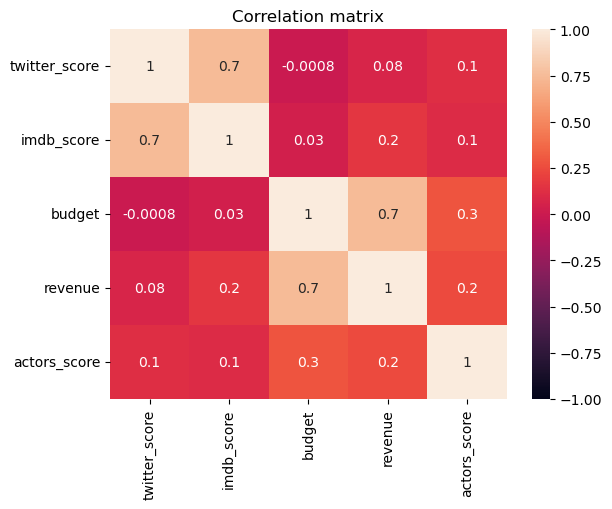

In [1947]:
ATI_final = pd.read_csv('ATI.csv')

data = ATI_final[['twitter_score','imdb_score','budget','revenue','actors_score']]
corr = data.corr()
#matrix = np.triu(corr)
sns.heatmap(corr, vmax=1.0, vmin=-1.0, fmt='.1g', annot=True)

plt.title('Correlation matrix')
plt.show()